In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import seaborn as sns

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Note - About file path

You could use the cell above to print the names of the file directories and get the following directories:

```
/kaggle/input/bttai-ajl-2025/sample_submission.csv
/kaggle/input/bttai-ajl-2025/train.csv
/kaggle/input/bttai-ajl-2025/test.csv
/kaggle/input/bttai-ajl-2025/test/test/e0374ae6c1362ff183cfba28ded5421b.jpg
/kaggle/input/bttai-ajl-2025/test/test/437159c605260bdd079af230566af291.jpg
...
...
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/11271bdf2598afdd4260db3125e1f6a5.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/732819951dcf2b53d15ea7b8bb123b71.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/6dcc7a8abb5e1c6e670101f4b6231246.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/e63c3b3f0ab8905e204fe467cc7411f9.jpg
...
...
```



## 1. Import Necessary Libraries

In [21]:
# 1. Import Necessary Libraries
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

tf.get_logger().setLevel('ERROR')
# Explanation:
# - pandas and numpy: for data manipulation
# - sklearn: for splitting data and encoding labels
# - tensorflow.keras: for building and training the neural network

## 2. Load Data

Make sure to verify the file paths if you're running on a different platform.

In [22]:
# 2. Load Data
train_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/train.csv')
test_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/test.csv')

# Add .jpg extension to md5hash column to reference the file_name
train_df['md5hash'] = train_df['md5hash'].astype(str) + '.jpg'
test_df['md5hash'] = test_df['md5hash'].astype(str) + '.jpg'

# Combine label and md5hash to form the correct path
train_df['file_path'] = train_df['label'] + '/' + train_df['md5hash']

In [23]:
# Check the first few rows to understand the structure
print(train_df.head())

                                md5hash  fitzpatrick_scale  \
0  fd06d13de341cc75ad679916c5d7e6a6.jpg                  4   
1  a4bb4e5206c4e89a303f470576fc5253.jpg                  1   
2  c94ce27e389f96bda998e7c3fa5c4a2e.jpg                  5   
3  ebcf2b50dd943c700d4e2b586fcd4425.jpg                  3   
4  c77d6c895f05fea73a8f3704307036c0.jpg                  1   

   fitzpatrick_centaur                             label nine_partition_label  \
0                    4                 prurigo-nodularis     benign-epidermal   
1                    1  basal-cell-carcinoma-morpheiform  malignant-epidermal   
2                    5                            keloid         inflammatory   
3                    3              basal-cell-carcinoma  malignant-epidermal   
4                    1                 prurigo-nodularis     benign-epidermal   

  three_partition_label            qc  ddi_scale  \
0                benign           NaN         34   
1             malignant           Na

<ipython-input-24-de4554e4b9df>:25: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


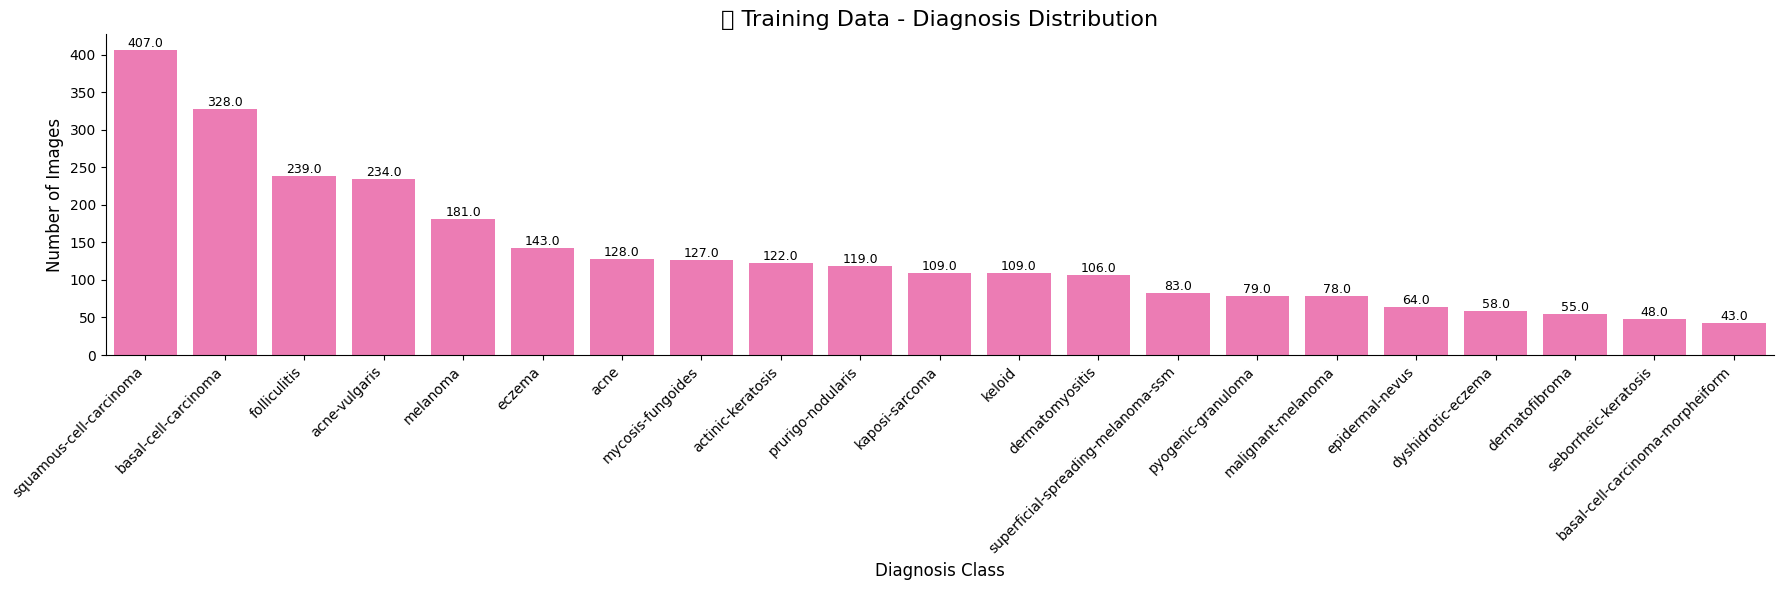

In [24]:
# exploratory data analysis
# class distribution (label column)
plt.figure(figsize=(18, 6))
ax = sns.countplot(
    data=train_df, 
    x='label', 
    order=train_df['label'].value_counts().index,
    color='#FF69B4'  # hot pink 💖
)
plt.title('🔬 Training Data - Diagnosis Distribution', fontsize=16)
plt.xlabel('Diagnosis Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')

# annotate values on top of bars
for bar in ax.patches:
    ax.annotate(
        format(bar.get_height(), ','), 
        (bar.get_x() + bar.get_width() / 2., bar.get_height()),
        ha='center', va='bottom',
        fontsize=9
    )

sns.despine()
plt.tight_layout()
plt.show()

<ipython-input-27-edc26e6698bc>:15: UserWarning: Glyph 129489 (\N{ADULT}) missing from current font.
  plt.tight_layout()
<ipython-input-27-edc26e6698bc>:15: UserWarning: Glyph 127998 (\N{EMOJI MODIFIER FITZPATRICK TYPE-5}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129489 (\N{ADULT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127998 (\N{EMOJI MODIFIER FITZPATRICK TYPE-5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


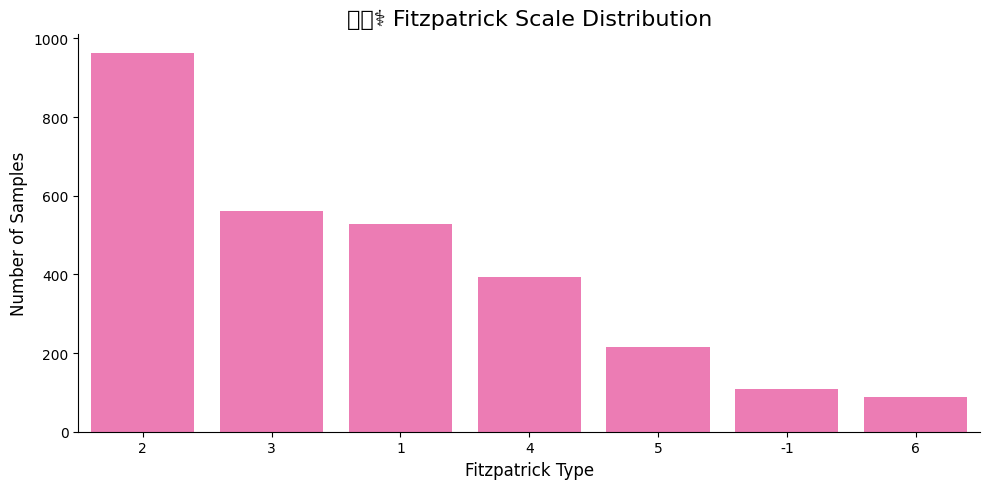

In [27]:
# checking skin tone distribution - fitzpatrick scale
# classifies skin tone based on how skin reacts to UV light
plt.figure(figsize=(10, 5))
ax = sns.countplot(
    data=train_df,
    x='fitzpatrick_scale',
    order=train_df['fitzpatrick_scale'].value_counts().index,
    color='#FF69B4'
)
plt.title('🧑🏾‍⚕️ Fitzpatrick Scale Distribution', fontsize=16)
plt.xlabel('Fitzpatrick Type', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=0)
sns.despine()
plt.tight_layout()
plt.show()

<ipython-input-26-0259e20c9c47>:14: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


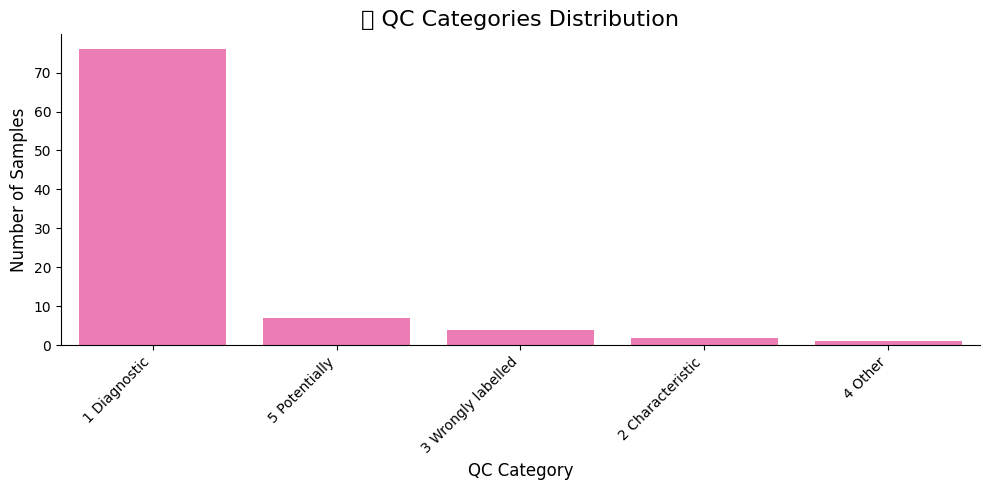

In [26]:
# quality control labels -n how cleam each image is
plt.figure(figsize=(10, 5))
ax = sns.countplot(
    data=train_df,
    x='qc',
    order=train_df['qc'].value_counts().index,
    color='#FF69B4'
)
plt.title('🔍 QC Categories Distribution', fontsize=16)
plt.xlabel('QC Category', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.tight_layout()
plt.show()

## 3. Data Preprocessing


This section demonstrates basic preprocessing techniques. To enhance data quality and model performance, consider incorporating more advanced preprocessing methods.

For further guidance, feel free to take a look at the [Image Preprocessing tutorial](https://colab.research.google.com/drive/1-ItNcRMbZBE6BCwPT-wD8m3YmHqwHxme?usp=sharing)  available in the 'Resources' section of this Kaggle competition.


In [33]:
# 🌸 STEP 3: Data Preprocessing 🌸

# label encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_df['encoded_label'] = label_encoder.fit_transform(train_df['label'])

# split into train and validation
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['encoded_label'],
    random_state=42
)

# handle class imbalance using class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data['encoded_label']),
    y=train_data['encoded_label']
)
class_weights_dict = dict(enumerate(class_weights))
print("🌸 Class Weights (to handle imbalance):", class_weights_dict)

# set image dimensions and batch size
img_size = (128, 128)
batch_size = 32

# define image directory (already prepped in earlier steps)
data_dir = "/kaggle/input/bttai-ajl-2025/train/train/"

# load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# save class names before caching
class_names = train_ds.class_names

# normalize pixel values (0-255 → 0-1)
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# improve performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


🌸 Class Weights (to handle imbalance): {0: 1.0577901063337956, 1: 0.5826330532212886, 2: 1.1117589893100097, 3: 0.41426760818395797, 4: 3.204481792717087, 5: 2.4761904761904763, 6: 1.2817927170868348, 7: 2.368530020703934, 8: 0.9474120082815735, 9: 2.1363211951447245, 10: 0.5704313138868112, 11: 1.2523262178434593, 12: 1.2523262178434593, 13: 1.7572964669738864, 14: 0.7513957307060756, 15: 1.0681605975723623, 16: 1.1468671679197995, 17: 1.7294028722600152, 18: 2.8671679197994986, 19: 0.334209757522641, 20: 1.6507936507936507}
Found 2860 files belonging to 21 classes.
Using 2288 files for training.
Found 2860 files belonging to 21 classes.
Using 572 files for validation.


<ipython-input-34-b972adee6945>:13: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


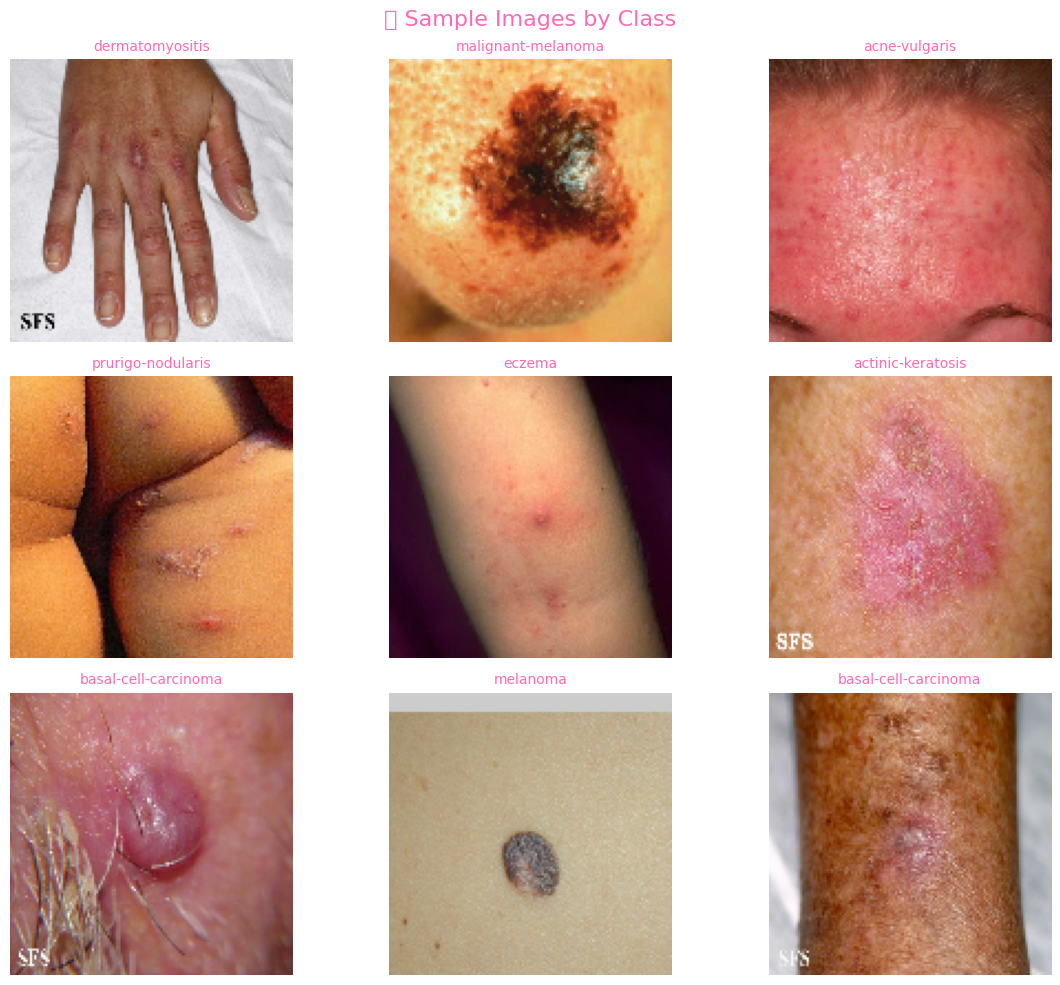

In [34]:
# show 9 random images
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
for images, labels in train_ds.take(1):  # One batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]], fontsize=10, color='#FF69B4')  # hot pink 💅🏽
        plt.axis("off")

plt.suptitle("✨ Sample Images by Class", fontsize=16, color='#FF69B4')
plt.tight_layout()
plt.show()

## 4. Build the model


In [44]:
from tensorflow.keras import layers, models, optimizers

def build_custom_model(input_shape=(128, 128, 3), num_classes=21):
    model = models.Sequential()

    # normalize pixel values
    model.add(layers.Rescaling(1./255, input_shape=input_shape))

    # conv Block 1
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # conv Block 2
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # conv Block 3
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # global Pooling & FC layers
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # compile
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_small_model(input_shape=(128, 128, 3), num_classes=21):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

## 5. Train the Model


In [52]:
small_model = build_small_model()

small_history = small_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,  # or even 3 just to sanity check
    verbose=1
)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 23s 306ms/step - accuracy: 0.1017 - loss: 3.1856 - val_accuracy: 0.1434 - val_loss: 2.9008
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 302ms/step - accuracy: 0.1445 - loss: 2.8273 - val_accuracy: 0.1573 - val_loss: 2.8223
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 23s 315ms/step - accuracy: 0.1850 - loss: 2.7115 - val_accuracy: 0.1486 - val_loss: 2.7623
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 308ms/step - accuracy: 0.2326 - loss: 2.5558 - val_accuracy: 0.1888 - val_loss: 2.7178
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - accuracy: 0.2976 - loss: 2.3504 - val_accuracy: 0.2063 - val_loss: 2.7764


## 6. Make Predictions on Test Data

In [58]:
# # 6. Make Predictions on Test Data
# # def preprocess_test_data(test_df, directory):
# """
# Template for loading and preprocessing test images.
# """
# # TODO: create a generator for the test set here.
# # test_datagen = ImageDataGenerator(rescale=1./255)
# # test_generator = test_datagen.flow_from_dataframe(
# #     .... ## set the test_generator here 
# # )
# # return test_generator
# 6. Make Predictions on Test Data
test_df['file_path'] = test_df['md5hash'].apply(lambda x: os.path.join(test_dir, x))
def preprocess_test_data(test_df, directory):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=directory,
        x_col='file_path',
        y_col=None,
        target_size=(128, 128),
        batch_size=32,
        shuffle=False,
        class_mode=None
    )
    return test_generator


In [59]:
test_dir = '/kaggle/input/bttai-ajl-2025/test/test/'  # adjust if needed
test_generator = preprocess_test_data(test_df, test_dir)


Found 1227 validated image filenames.


## 7. Generate Predictions

In [60]:
# TODO
# Generate predictions based on the trained model
# Then, save the predictions into a CSV file for submission
# Generate predictions using trained model
preds = small_model.predict(test_generator)
pred_labels = np.argmax(preds, axis=1)

# attach predictions to your test_df (or new DataFrame)
test_df['predicted_label'] = pred_labels

# save to CSV
test_df[['md5hash', 'predicted_label']].to_csv('submission.csv', index=False)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step
